Author: Matthias Rueedlinger, (public AT rueedlinger.ch)

GitHub: https://github.com/rueedlinger/monte_carlo_simulation/


# Forecasting with a Monte Carlo Simulation

This example tries to use a Monte Carlo simulation with cycle times from previous work items to simulate how long the rest of the work items could take. 

This article is inspired from previous publication from the agile / lean comunity where some ALM / issue trackers tools allow you to do some forecats based on a Monte Carlo simulation. For more details have look at the __reference section__ in the [README](https://github.com/rueedlinger/monte-carlo-simulation) of this GitHub project.

So my goal was to build a Monte Carlo simulation by my own.

## Get Started

First we need some python packages for our simulation.

- _matplotlib_ - for plotting  nice charts.
- _random_ - for our Monte Carlo simulation. By the way a Monte Carlo simulation is a fancy word from random sampling.
- _numpy_ - load data and calulcate the median, standard deviation and percentiles.
- _pandas_ - for the whole data wrangling stuff.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import random
import numpy as np
import pandas as pd

import scipy.stats as stats


## Let's first look at previous data (cycle times)

First let's load some pervious cycle times form a CVS file.

In [56]:
df = pd.read_csv('data.csv', parse_dates=['created_date'])

Next look at our dataset
- __grp__ - the project to which the work item belongs 
- __cycle_time_days__ - the cylce time in days from _todo_ stage to the _done_ stage. A cycle time -1 means the ticket was closed (rejected, won't fix, as design, etc.)
- __created_date__ - the date when the wokr item was created

In [59]:
df.head()

,id,grp,cycle_time_days,created_date
0,5052,0,-1,2015-02-05
1,326,0,-1,2013-12-25
2,5056,0,-1,2015-10-16
3,324,0,18,2013-08-13
4,325,0,-1,2013-12-25


In [111]:
cleaned = df[df['created_date'] > '2017-12-31']
cleaned = cleaned[cleaned['cycle_time_days'] > -1]


project_0_cycle_times = cleaned[cleaned['grp'] == 0].cycle_time_days
project_1_cycle_times = cleaned[cleaned['grp'] == 1].cycle_time_days

project_0_cycle_times = project_0_cycle_times.values
project_1_cycle_times = project_1_cycle_times.values

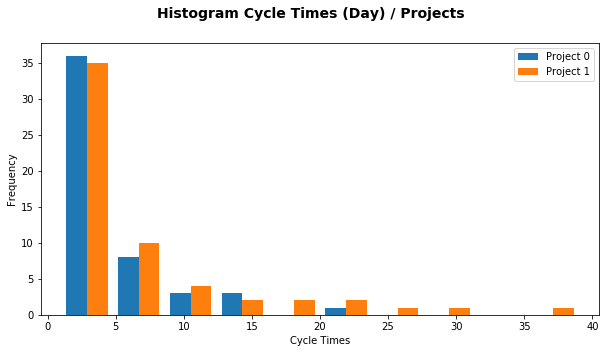

In [112]:

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Histogram Cycle Times (Days)', fontsize=14, fontweight='bold')
plt.hist([project_0_cycle_times, project_1_cycle_times], label=['Project 0', 'Project 1'])
ax.set_xlabel('Cycle Times')
ax.set_ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

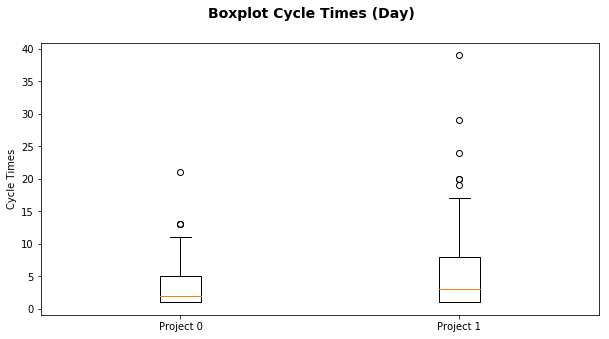

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Boxplot Cycle Times (Day)', fontsize=14, fontweight='bold')

plt.boxplot([project_0_cycle_times, project_1_cycle_times])

ax.set_xticklabels(['Project 0', 'Project 1'])
ax.set_ylabel('Cycle Times')


plt.show()

Some descriptive statistics for our cycle times

In [128]:
print(stats.describe(project_0_cycle_times))
print(stats.describe(project_1_cycle_times))

DescribeResult(nobs=51, minmax=(1, 21), mean=3.7058823529411766, variance=17.93176470588235, skewness=2.0789642149745884, kurtosis=4.474217402617895)
DescribeResult(nobs=58, minmax=(1, 39), mean=6.327586206896552, variance=61.2416817906836, skewness=2.146885333051502, kurtosis=4.8044881900831315)


An the coefficient of variation (CV).

In [129]:
print(stats.variation(project_0_cycle_times))
print(stats.variation(project_1_cycle_times))

1.131409450013304
1.2260520692931383


## Monte Carlo Simulation for Project 0 

Let's simulate when could have we finished the nex 30 work items.

In [116]:
total_work_items = 30

def cumulative_sum(total_work_items, cycle_times, selector):
    total = [0]
    for i, e in enumerate(range(total_work_items)):
            total.append(selector(cycle_times) + total[i])
    return total    

In [117]:
cumulative_sum_min = cumulative_sum(total_work_items, project_0_cycle_times, min)
cumulative_sum_max = cumulative_sum(total_work_items, project_0_cycle_times, max)
cumulative_random = cumulative_sum(total_work_items, project_0_cycle_times, random.choice)

In [118]:
range_work_items = [x for x in range(total_work_items + 1)]

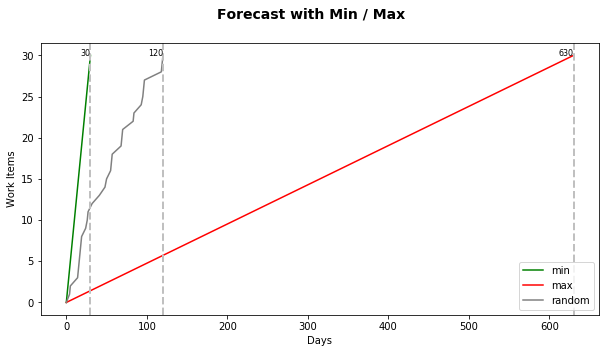

In [119]:

fig, ax = plt.subplots(figsize=(10, 5))


fig.suptitle('Forecast with Min / Max', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(cumulative_random, range_work_items, label='random', color='gray')

value_max = cumulative_sum_max[-1]
value_min = cumulative_sum_min[-1]
value_random =  cumulative_random[-1]

plt.axvline(value_max, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_min, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_random, color='silver', linestyle='dashed', linewidth=2)

t = ax.text(value_max, total_work_items, value_max, ha="right", size=8)
t = ax.text(value_min, total_work_items, value_min, ha="right", size=8)
t = ax.text(value_random, total_work_items, value_random, ha="right", size=8)

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')


plt.show()

#ax.xaxis.tick_top()

In [135]:
num_of_iterations = 1000

def simulate(num_of_iterations, total_work_items, cycle_times):
    list_random_walks = []
    totals = []
    
    for i in range(num_of_iterations):
        list_random_walks.append(
            cumulative_sum(total_work_items, cycle_times, random.choice))
    
    for i in list_random_walks:
        totals.append(i[-1])
    
    return totals, list_random_walks

simulated_total, simulated_work_done = simulate(num_of_iterations, total_work_items, project_0_cycle_times)

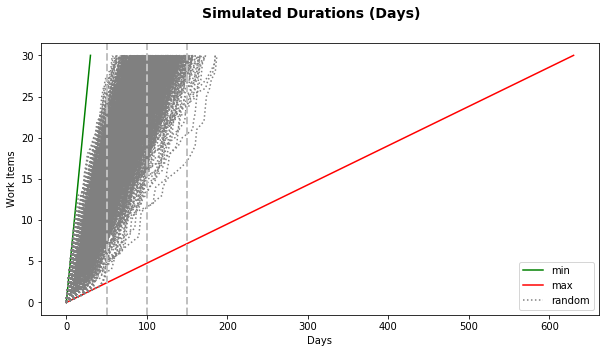

In [136]:
fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Simulated Durations (Days)', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(0, 0, linestyle='dotted', color='gray', label='random')


for r in simulated_work_done:
    plt.plot(r, range_work_items, linestyle='dotted', color='gray')

plt.axvline(50, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(100, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(150, color='silver', linestyle='dashed', linewidth=2)

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')
plt.show()


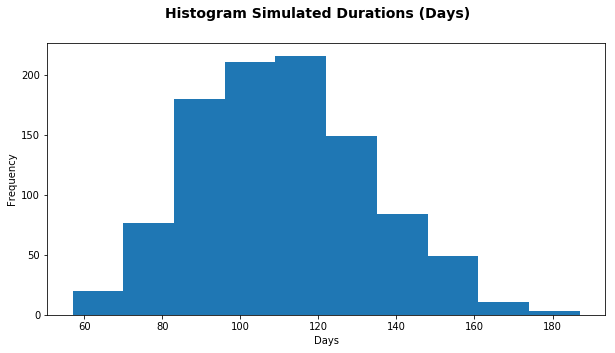

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Histogram Simulated Durations (Days)', fontsize=14, fontweight='bold')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
plt.hist(simulated_total);

With a 10'000 run I got


    [109.   135.   141.   151.   170.01]

Let's check waht we got with our run.

In [140]:
q = [50, 85, 90, 95, 99]
p = np.percentile(simulated_total, q)
print(p)

[109.  134.  139.1 150.  166. ]


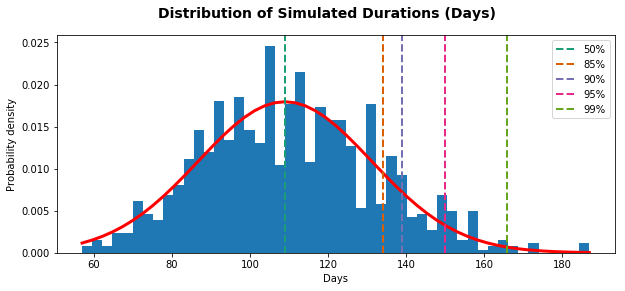

In [139]:
fig, ax = plt.subplots(figsize=(10, 4))

fig.suptitle('Distribution of Simulated Durations (Days)', fontsize=14, fontweight='bold')

num_bins = 50

mu = np.median(simulated_total)
sigma = np.std(simulated_total)

# the histogram of the data
n, bins, patches = ax.hist(simulated_total, num_bins, normed=1)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
ax.plot(bins, y, color='red', linestyle='solid', linewidth=3)
ax.set_xlabel('Days')
ax.set_ylabel('Probability density')

cm = plt.cm.get_cmap('Dark2')


for i, v in enumerate(p):
    plt.axvline(v, color=cm.colors[i], linestyle='dashed', linewidth=2, label=str(q[i]) + '%')

plt.legend(loc='upper right')
plt.show()